In [2]:
import pandas as pd
import numpy as np
import time
from datetime import timezone

import requests
from requests.adapters import HTTPAdapter
from requests import Session

import re
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk import ngrams
import unicodedata

import json
import urllib3

import arango
from arango import ArangoClient
from arango.response import Response
from arango.http import HTTPClient

In [3]:
from sklearn import preprocessing

In [4]:
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, NGram, HashingTF, MinHashLSH, CountVectorizer
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, LongType
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [5]:
pd.set_option('display.max_colwidth', -1)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import warnings
warnings.filterwarnings("ignore")

# Funciones auxiliares

In [6]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('Elapsed time: {}'.format(end-start))
        return result
    return wrapper

In [7]:
import logging

from requests.adapters import HTTPAdapter
from requests import Session

from arango.response import Response
from arango.http import HTTPClient


class CustomHTTPClient(HTTPClient):
    """My custom HTTP client with cool features."""

    def __init__(self):
        self._session = Session()
        # Initialize your logger.
        self._logger = logging.getLogger('my_logger')

    def create_session(self, host):
        session = Session()

        # Add request header.
        session.headers.update({'x-my-header': 'true'})

        # Enable retries.
        adapter = HTTPAdapter(max_retries=5)
        self._session.mount('https://', adapter)

        return session

    def send_request(self,
                     session,
                     method,
                     url,
                     params=None,
                     data=None,
                     headers=None,
                     auth=None):
        # Add your own debug statement.
        self._logger.debug('Sending request to {}'.format(url))

        # Send a request.
        response = session.request(
            method=method,
            url=url,
            params=params,
            data=data,
            headers=headers,
            auth=auth,
            verify=False  # Disable SSL verification
        )
        self._logger.debug('Got {}'.format(response.status_code))

        # Return an instance of arango.response.Response.
        return Response(
            method=response.request.method,
            url=response.url,
            headers=response.headers,
            status_code=response.status_code,
            status_text=response.reason,
            raw_body=response.text,
        )

In [8]:
@timing
def execute(query):
    cursor = aql.execute(query)
    item_keys = [doc for doc in cursor]
    return item_keys

In [9]:
# Extraccion de emails
def textCleansing(text):
    text = re.sub('[^A-Za-z0-9@ _.+-]+', ' ', text)
    return str(text).replace('  ', ' ')

def emailExtraction(text):
    emails = list()    
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
    return re.findall(pattern, text)

In [10]:
def textNormalize(text):
    text = str(text).lower()
    text = re.sub('[^a-zA-Z ]', '', str(text))
    text = unicodedata.normalize('NFD', text)
    return str(text)

In [11]:
def extractUrlMimecast(x):
    x = str(x).replace('orgsMimecast/','')
    url_body = x.split('.')
    url_body = url_body[0:len(url_body)-1]
    return ''.join(url_body)

s-gltd
commsflightglobal


# Conexion a la BBDD

In [13]:
# Mi local
client = ArangoClient(hosts='https://localhost:XXXX/', http_client=CustomHTTPClient())
db = client.db('gp', username='root', password='kXaHdJJoKi')
aql = db.aql
pregel = db.pregel


#-------------------------------------------------------------
# PRUEBA DE CONEXION - Nº de documentos

collection = 'peopleMimecast'
query=r'''RETURN LENGTH(''' + collection + ''')'''
print(query)
execute(query)

RETURN LENGTH(peopleMimecast)
Elapsed time: 0.15740203857421875


[81865]

# Personas y Empresas de Arango

In [11]:
col = db.collection('peopleExtraction')
pd_people = pd.DataFrame(list(col))
pd_people = pd_people[pd_people.type == 'name']
pd_people['name_nfd'] = pd_people.value.apply(lambda x: textNormalize(x))
pd_people = pd_people[['key_peopleMaster','id_originally', 'name_nfd']]
pd_people.head(3)

,key_peopleMaster,id_originally,name_nfd
2,1572888328-146432611,peopleMimecast/lucia.o'keeffe@gpbullhound.com,lucia okeeffe
4,1572888328-60469414,peopleMimecast/lucia@gpbullhound.com,lucia okeeffe
11,1572888328-128185389,peoplePipedrive/306203,lucia o keeffe


In [12]:
# Vamos a quedarnos con las personas que tienen más de una palabra
pd_people_2 = pd_people[['key_peopleMaster', 'name_nfd']]
pd_people_2.name_nfd = pd_people_2.name_nfd.apply(lambda x: x.strip())
pd_people_2 = pd_people_2.drop_duplicates()
pd_people_2 = pd_people_2[pd_people_2.name_nfd.str.contains(' ')]
print(len(pd_people))
print(len(pd_people_2))
pd_people_2.head(3)

299764
193999


,key_peopleMaster,name_nfd
2,1572888328-146432611,lucia okeeffe
4,1572888328-60469414,lucia okeeffe
11,1572888328-128185389,lucia o keeffe


In [13]:
# Trabajamos en spark
schema = StructType([StructField("key_peopleMaster", StringType(), True),
                     StructField("name_nfd", StringType(), True)])
df_people = spark.createDataFrame(pd_people_2, schema=schema)
df_people.show(2, False)

+--------------------+-------------+
|key_peopleMaster    |name_nfd     |
+--------------------+-------------+
|1572888328-146432611|lucia okeeffe|
|1572888328-60469414 |lucia okeeffe|
+--------------------+-------------+
only showing top 2 rows



In [14]:
col = db.collection('orgPipedrive')
pd_orgPipedrive = pd.DataFrame(list(col))
pd_orgPipedrive['name_nfd'] = pd_orgPipedrive.name.apply(lambda x: textNormalize(x))
pd_orgPipedrive = pd_orgPipedrive[['_id','name','name_nfd']]
pd_orgPipedrive.columns = ['id_originally', 'name', 'name_nfd']
print(len(pd_orgPipedrive))
# pd_orgPipedrive.head(3)

col = db.collection('orgsMimecast')
pd_orgMimecast = pd.DataFrame(list(col))
pd_orgMimecast['name'] = pd_orgMimecast._id.apply(lambda x: extractUrlMimecast(x))
pd_orgMimecast['name_nfd'] = pd_orgMimecast.name.apply(lambda x: textNormalize(x))
pd_orgMimecast = pd_orgMimecast[['_id','name','name_nfd']]
pd_orgMimecast.columns = ['id_originally', 'name', 'name_nfd']
print(len(pd_orgMimecast))
# pd_orgMimecast.head(3)

pd_orgs = pd.concat([pd_orgPipedrive, pd_orgMimecast])
print(len(pd_orgs))
pd_orgs.head(3)

37450
28876
66326


,id_originally,name,name_nfd
0,orgPipedrive/39497,RedMere Technology,redmere technology
1,orgPipedrive/65382,Gestaweb 2020,gestaweb
2,orgPipedrive/69002,Remy Valette,remy valette


In [15]:
# Trabajamos en spark
schema = StructType([StructField("id_originally", StringType(), True),\
                     StructField("name", StringType(), True),\
                     StructField("name_nfd", StringType(), True)])
df_orgs = spark.createDataFrame(pd_orgs, schema=schema)
df_orgs.show(2, False)

+------------------+------------------+------------------+
|id_originally     |name              |name_nfd          |
+------------------+------------------+------------------+
|orgPipedrive/39497|RedMere Technology|redmere technology|
|orgPipedrive/65382|Gestaweb 2020     |gestaweb          |
+------------------+------------------+------------------+
only showing top 2 rows



In [16]:
df_orgs_2 = df_orgs.filter(F.length(F.col('name_nfd'))>3)

# Carga de documentos

In [72]:
#col = db.collection('documents')
#doc = col.get({'_key':'c553fd1d-87d0-483a-96cb-3ff54c690241'})
#doc = col.get({'_key':'23e03a6b-8570-48c0-bd83-dfbd08622d6b'}) # email
#doc = col.get({'_key':'87832f42-c0fa-4366-86c4-097497efeb5f'})
#text = doc['text']

In [141]:
collection = 'documents'
query=r'''FOR d IN '''+collection+'''
  RETURN { key: d._key, text: d.text, uploader: d.uploaded_by, created: d.created_at, updated: d.updated_at }
'''
print(query)
col = execute(query)

FOR d IN documents
  RETURN { key: d._key, text: d.text, uploader: d.uploaded_by, created: d.created_at, updated: d.updated_at }

Elapsed time: 213.46108198165894


In [142]:
pd_documents = pd.DataFrame(list(col))

In [143]:
pd_documents.to_csv('output/pd_documents.csv', index=False)

# Busquedad de Entidades

In [146]:
def find_entities2(entities):
    """
    Gets dataframe output of StanfordNER tagger
    and finds entities by looking at consecutive indices.
    
    input : entities - DataFrame with tagged words StanfordNER tagger (output)
    output : list - entities (PERSON, ORGANIZATION)
    """

    x = entities.index.values
    L = []

    i = 0
    while i < len(x):
        l = [x[i]]
        j = i + 1
        while (j < len(x)) and (x[j]-x[j-1]==1):
            l.append(x[j])
            j = j + 1
        L.append(l)
        i = j
        
    return [[' '.join(list(entities.loc[l, 'word'])), ' '.join(list(entities.loc[l, 'label'].unique()))] for l in L]

In [68]:
folder1 = '/home/acalle/Documentos/GP-bullhound/stanford-ner-2018-10-16/classifiers/'
st = StanfordNERTagger(folder1+'english.all.3class.distsim.crf.ser.gz')


***********************************

### Función: findEntityInText(text, orgsDF, peopleDF)

***********************************

In [161]:
def findEntityInText(dict_text, df_orgs, df_people):
    """
    Recibe un texto y encuentra entidades (empresas y personas) en ese texto. 
    Devuelve la ID del texto y las entidades encontradas.
    
    :param: - dict_text - diccionario {'key', 'text', 'uploaded_by', 'updated_at'}
    :param: - df_orgs - SparkDF con información de organizaciones (orgPipedrive, orgMimecast)
    :param: - df_people - SparkDF con información de personas (peopleExtraction)
    """

    key = dict_text['key']
    text = dict_text['text']
    uploader = dict_text['uploader']
    created = dict_text['created']    
    updated = dict_text['updated']        
    
    if len(text)==0: 
        return [key, 'No text in document']
    
    #filter names with more than three characters:
    df_orgs_2 = df_orgs.filter(F.length(F.col('name_nfd'))>3)
    df_people_2 = df_people.filter(F.length(F.col('name_nfd'))>3)
    
    #NER entities
    labelled = st.tag(text.split())
    labelled = pd.DataFrame(labelled, columns=['word', 'label'])
    entities = labelled[((labelled.label == 'PERSON') | (labelled.label == 'ORGANIZATION')) & (len(labelled.word)>1)]
    entities = find_entities2(entities)
    entities = pd.DataFrame(entities).drop_duplicates().reset_index(drop=True)
    entities.columns = ['entity', 'type']

    #spark df entities
    schema = StructType([StructField("entity", StringType(), True),\
                         StructField("type", StringType(), True)])
    df_entities = spark.createDataFrame(entities, schema=schema)
    df_entities_2 = df_entities.withColumn('name_nfd', F.trim(F.lower(F.col('entity'))))\
                               .filter(F.length(F.col('name_nfd'))>3)
        
    # -----------------------
    #fuzzy orgs vs. entities
    # -----------------------   

    #hashing model
    model = Pipeline(stages=[
        RegexTokenizer(pattern="", inputCol="name_nfd", outputCol="tokens", minTokenLength=1),
        NGram(n=3, inputCol="tokens", outputCol="ngrams"),
        HashingTF(inputCol="ngrams", outputCol="vectors"),
        MinHashLSH(inputCol="vectors", outputCol="lsh", numHashTables=5)
    ])    
    model = model.fit(df_orgs_2)    
    df_orgs_hashed = model.transform(df_orgs_2)
    df_entities_hashed = model.transform(df_entities_2)
    
    #similitud
    threshold = 0.4
    results_names = model.stages[-1]\
                     .approxSimilarityJoin(df_orgs_hashed, df_entities_hashed, threshold, distCol="dist_jaccard")\
                     .select(
                            F.col("datasetA.id_originally"),
                            F.col("datasetA.name"),
                            F.col("datasetB.entity"),
                            F.col("dist_jaccard"))
    pd_results1 = results_names.toPandas()    
    
    # -------------------------
    #fuzzy people vs. entities
    # -------------------------  
    #hashing model
    model = Pipeline(stages=[
        RegexTokenizer(pattern="", inputCol="name_nfd", outputCol="tokens", minTokenLength=1),
        NGram(n=3, inputCol="tokens", outputCol="ngrams"),
        HashingTF(inputCol="ngrams", outputCol="vectors"),
        MinHashLSH(inputCol="vectors", outputCol="lsh", numHashTables=5)
    ])    
    model = model.fit(df_people_2)
    df_people_hashed = model.transform(df_people_2)
    df_entities_hashed = model.transform(df_entities_2)
    
    #similitud
    threshold = 0.4
    results_names = model.stages[-1]\
                     .approxSimilarityJoin(df_people_hashed, df_entities_hashed, threshold, distCol="dist_jaccard")\
                     .select(
                            F.col("datasetA.key_peopleMaster"),
                            F.col("datasetA.name_nfd"),
                            F.col("datasetB.entity"),
                            F.col("dist_jaccard"))
    pd_results2 = results_names.toPandas()
    
    return pd_results1, pd_results2



In [153]:
df_orgs.show(2)

+------------------+------------------+------------------+
|     id_originally|              name|          name_nfd|
+------------------+------------------+------------------+
|orgPipedrive/39497|RedMere Technology|redmere technology|
|orgPipedrive/65382|     Gestaweb 2020|         gestaweb |
+------------------+------------------+------------------+
only showing top 2 rows



In [154]:
df_people.show(2)

+--------------------+-------------+
|    key_peopleMaster|     name_nfd|
+--------------------+-------------+
|1572888328-146432611|lucia okeeffe|
| 1572888328-60469414|lucia okeeffe|
+--------------------+-------------+
only showing top 2 rows



In [162]:
dict_text = col[14]
pd_results1, pd_results2 = findEntityInText(dict_text, df_orgs, df_people)

In [163]:
pd_results1

,id_originally,name,entity,dist_jaccard
0,orgsMimecast/galec.fr,galec,Alec,0.333333
1,orgPipedrive/73283,GP Bullhound LLP,Bullhound LLP,0.214286


In [164]:
pd_results2

,key_peopleMaster,name_nfd,entity,dist_jaccard
0,1571762370-146607949,bullhound lux,Bullhound LLP,0.307692


## Análisis del resultado de la Pipeline en Sparta de Yessica-Chema:

Esta parte del notebook hace uso de la colección generada por Yessica donde se ha implementado una caja con NER en Java. 

El resultado de la pipeline es la colección `master_documents_ner` que da información del tipo persona A (`_from`) se relaciona con persona B (`_to`) en documento X (`id_document`).

In [10]:
# Tunel local de Yessika 
client = ArangoClient(hosts='http://10.90.3.65:8529', http_client=CustomHTTPClient())
db = client.db('gp', username='root', password='openSesame')
aql = db.aql
pregel = db.pregel

#-------------------------------------------------------------
# PRUEBA DE CONEXION - Nº de documentos

collection = 'documents_NER'
query=r'''RETURN LENGTH(''' + collection + ''')'''
print(query)
execute(query)

RETURN LENGTH(documents_NER)
Elapsed time: 0.06807780265808105


[1218]

In [11]:
col = db.collection('master_documents_ner')
pd_documents = pd.DataFrame(list(col))
print(pd_documents.shape)
pd_documents.head(1)

(1490, 10)


,_key,_id,_from,_to,_rev,id_document,created,updated,uploader,dateIngested
0,peopleMaster-1571760048-87547557_peopleMaster-1571816181-67616465,master_documents_ner/peopleMaster-1571760048-87547557_peopleMaster-1571816181-67616465,peopleMaster/1571760048-87547557,peopleMaster/1571816181-67616465,_ZjkJwtS-_P,documents/0002c246-92fe-4a26-a284-d64f7066e038,2017-01-30T07:18:25.000Z,2017-01-30T07:20:49.133Z,__del__20__martin.yang,2019-11-11T08:19:24.016Z


In [13]:
pd_documents.columns

Index(['_key', '_id', '_from', '_to', '_rev', 'id_document', 'created',
       'updated', 'uploader', 'dateIngested'],
      dtype='object')

In [12]:
col = db.collection('peopleMaster')
pd_peopleMaster = pd.DataFrame(list(col))
pd_peopleMaster.head(1)

,_key,_id,_rev,name,email,address,phone,job_position,job_company,active_flag,principal_name,dateIngested,image_url,updated_date,closeness,aggregateData,aggregatedData,date_omni,date_omi
0,1571760048-1185557,peopleMaster/1571760048-1185557,_ZiZGKU2---,"[Christian, Albrecht, Christian Albrecht]","[christian@nordwindcapital.com, ute.henzgen@ip.de, christian.albrecht@wincor-nixdorf.com]",[Berliner Str. 44 Hilden 40721 Germany Nordrhein-Westfalen Düsseldorf Germany Hilden 40721 Berliner Straße 44],"[0210390181130, +492103901130, 9268725, 02103901130, +49210390181130, +491709268725]",[Leitung Business Development Marketing],"[Mediengruppe RTL / IP Deutschland GmbH, Wincor Nixdorf International GmbH]",False,Christian Albrecht,null,,2019-11-04T17:27:03.581Z,NaN,NaN,NaN,NaN,NaN


In [18]:
pd_peopleMaster.loc[pd_peopleMaster._id == "peopleMaster/1571760048-87547557", ["name", "job_company"]]

,name,job_company
209632,"[jonathan cantwell, jonathan.cantwell, Jonathan Cantwell]","[GP Bullhound, gpbullhound, Teamdynamix]"


In [48]:
def findDocumentRelations(pd_documents, pd_peopleMaster):
    """
    Find relations between people associated to a document
    
    - inputs:
    :param: pd_documents - pandas.DataFrame from ArangoDB 'master_documents_ner' collection
    :param: pd_peopleMaster - pandas.DataFrame from ArangoDB 'peopleMaster' collection

    - output:
    :out: dictionary - (key =document_id / value=pandas.DataFrame with people relations)
    """

    docRelations_keys = []
    docRelations_vals = []

    for id_doc in pd_documents.id_document.unique():

        print('document_id: {}\n'.format(id_doc))

        found_keys = pd_documents.loc[pd_documents.id_document == id_doc, ['_from', '_to']]    
        pd_from = found_keys.merge(pd_peopleMaster, left_on='_from', right_on='_id')[["_to", "_key", "job_company", "principal_name"]].rename(columns={"_key":"from_key", "job_company":"from_company", "principal_name":"from_name"})
        pd_relations = pd_from.merge(pd_peopleMaster, left_on='_to', right_on='_id')[["from_key", "from_name", "from_company", "_key", "principal_name", "job_company"]].rename(columns={"_key":"to_key", "principal_name":"to_name", "job_company":"to_company"})

        # store relations
        docRelations_keys.append(id_doc)
        docRelations_vals.append(pd_relations)

        print('stored ...')

    return dict(zip(docRelations_keys, docRelations_vals))
    
dic_docRelations = findDocumentRelations(pd_documents, pd_peopleMaster)

document_id: documents/0002c246-92fe-4a26-a284-d64f7066e038

stored ...
document_id: documents/0002890d-a244-44a5-ae58-d54b4c8caf29

stored ...
document_id: documents/00c81ad1-489d-40f3-b742-386773a30b86

stored ...
document_id: documents/00cb122d-5b00-420b-9f91-874c7d553b6c

stored ...
document_id: documents/00c94c03-f547-42f2-82ec-af4a5af98042

stored ...
document_id: documents/00e2ea53-461d-430e-b23a-038ad153dc21

stored ...
document_id: documents/00d68b2f-7466-4405-9562-0ef7ea391a01

stored ...


In [51]:
dic_docRelations['documents/0002c246-92fe-4a26-a284-d64f7066e038']

,from_key,from_name,from_company,to_key,to_name,to_company
0,1571760048-87547557,Cantwell Jonathan,"[GP Bullhound, gpbullhound, Teamdynamix]",1571816181-67616465,Neeraj Agrawal,[Battery Ventures]
1,1571816884-51197037,Okan Inaltay,"[GP Bullhound, gpbullhound, Beyond Limits]",1571816181-67616465,Neeraj Agrawal,[Battery Ventures]
2,1571761769-4974821,Nicholls Simon,[gpbullhound],1571816181-67616465,Neeraj Agrawal,[Battery Ventures]
3,1571824562-83745457,Simon Nicholls,"[GP Bullhound, simonnicholls, gpbullhound, justineduggan, GPBullhound]",1571816181-67616465,Neeraj Agrawal,[Battery Ventures]
4,1571760048-87547557,Cantwell Jonathan,"[GP Bullhound, gpbullhound, Teamdynamix]",1571760650-41108116,Lieberman Jeffrey,"[Insight Venture Partners, Insight Partners, Manish Madhvani, insightpartners]"
5,1571816884-51197037,Okan Inaltay,"[GP Bullhound, gpbullhound, Beyond Limits]",1571760650-41108116,Lieberman Jeffrey,"[Insight Venture Partners, Insight Partners, Manish Madhvani, insightpartners]"
6,1571761769-4974821,Nicholls Simon,[gpbullhound],1571760650-41108116,Lieberman Jeffrey,"[Insight Venture Partners, Insight Partners, Manish Madhvani, insightpartners]"
7,1571824562-83745457,Simon Nicholls,"[GP Bullhound, simonnicholls, gpbullhound, justineduggan, GPBullhound]",1571760650-41108116,Lieberman Jeffrey,"[Insight Venture Partners, Insight Partners, Manish Madhvani, insightpartners]"
8,1571760048-87547557,Cantwell Jonathan,"[GP Bullhound, gpbullhound, Teamdynamix]",1571762370-113919514,Vishal Bhagwati,"[Oracle Corporation, Oracle]"
9,1571816884-51197037,Okan Inaltay,"[GP Bullhound, gpbullhound, Beyond Limits]",1571762370-113919514,Vishal Bhagwati,"[Oracle Corporation, Oracle]"


## Cálculo del peso documental

In [52]:
pd_documents.head(1)

,_key,_id,_from,_to,_rev,id_document,created,updated,uploader,dateIngested
0,peopleMaster-1571760048-87547557_peopleMaster-1571816181-67616465,master_documents_ner/peopleMaster-1571760048-87547557_peopleMaster-1571816181-67616465,peopleMaster/1571760048-87547557,peopleMaster/1571816181-67616465,_ZjkJwtS-_P,documents/0002c246-92fe-4a26-a284-d64f7066e038,2017-01-30T07:18:25.000Z,2017-01-30T07:20:49.133Z,__del__20__martin.yang,2019-11-11T08:19:24.016Z


In [57]:
# limpia el dataframe
pd_documents = pd_documents[['_from', '_to', 'id_document', 'updated']]
pd_documents.columns = ['from', 'to', 'id', 'date']

pd_documents['date'] = pd_documents.date.apply(lambda x: str(x)[0:10])
pd_documents['from'] = pd_documents['from'].apply(lambda x: str(x).replace('peopleMaster/',''))
pd_documents['to'] = pd_documents['to'].apply(lambda x: str(x).replace('peopleMaster/',''))
pd_documents['id'] = pd_documents['id'].apply(lambda x: str(x).replace('documents/',''))

In [58]:
pd_documents.head(1)

,from,to,id,date
0,1571760048-87547557,1571816181-67616465,0002c246-92fe-4a26-a284-d64f7066e038,2017-01-30


In [85]:
alpha = 0.5
q = 1.6
p = 1
factor = 10**7

#min-max scaler
scaler = preprocessing.MinMaxScaler()

#current utc timestamp
t0 = time.time()/factor

#set timezone of datetime object to utc and calculates the timestamp
pd_documents['t'] = pd.to_datetime(pd_documents.date).apply(lambda x: x.replace(tzinfo=timezone.utc).timestamp()/factor)

#weight is decreasing with time
pd_documents['t-t0'] = pd_documents['t'] - t0
pd_documents['weight'] = q * np.exp( alpha * pd_documents['t-t0'] )

#sum over interaction pairs
final = pd_documents[['from', 'to', 'id', 'date', 'weight']].groupby(['from', 'to']).sum().reset_index()

#apply log-transformation to compensate for highly interecting people
final['weight'] = np.log1p( final['weight'] )

#scale to be a number in range [0,1] and return the complement 
final['weight'] = (1 - scaler.fit_transform(final['weight'].values.reshape(-1,1)))


In [86]:
[final.weight.min(), final.weight.max()]

[0.0, 1.0]

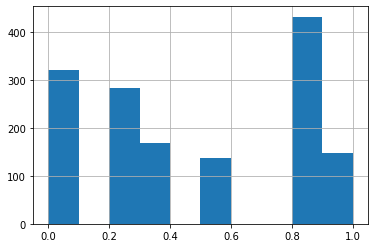

In [89]:
final.weight.hist(bins=10)